In [1]:
import GPy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv

from tqdm import tqdm
import haversine as hs
import networkx as nx

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
torch.manual_seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


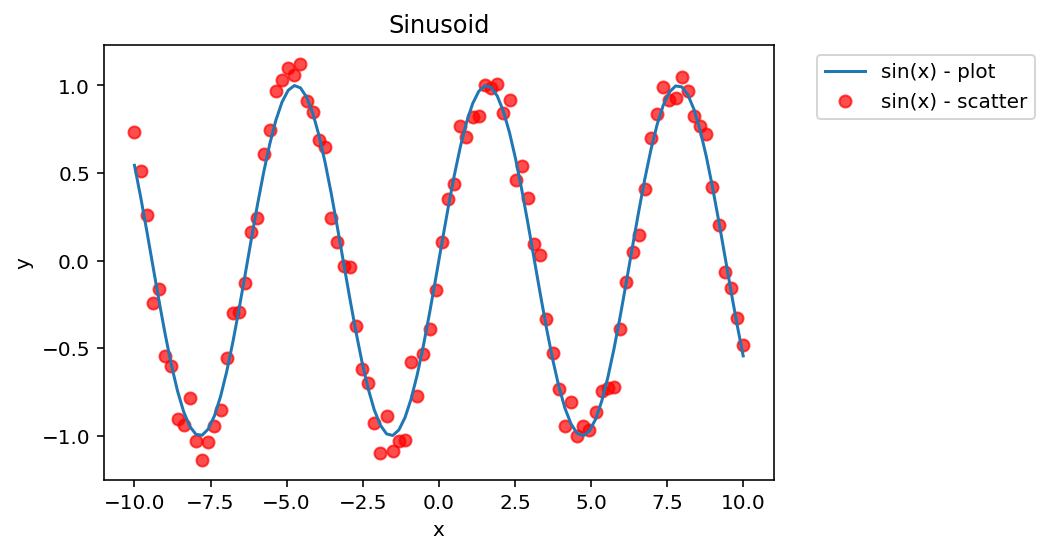

In [2]:
n_points = 100

x = torch.linspace(-10, 10, n_points)

y = torch.sin(x) + torch.randn(n_points) * 0.1
plt.plot(x, torch.sin(x) );
plt.scatter(x, y, c = 'red', alpha = 0.7);
plt.title('Sinusoid');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['sin(x) - plot', 'sin(x) - scatter'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

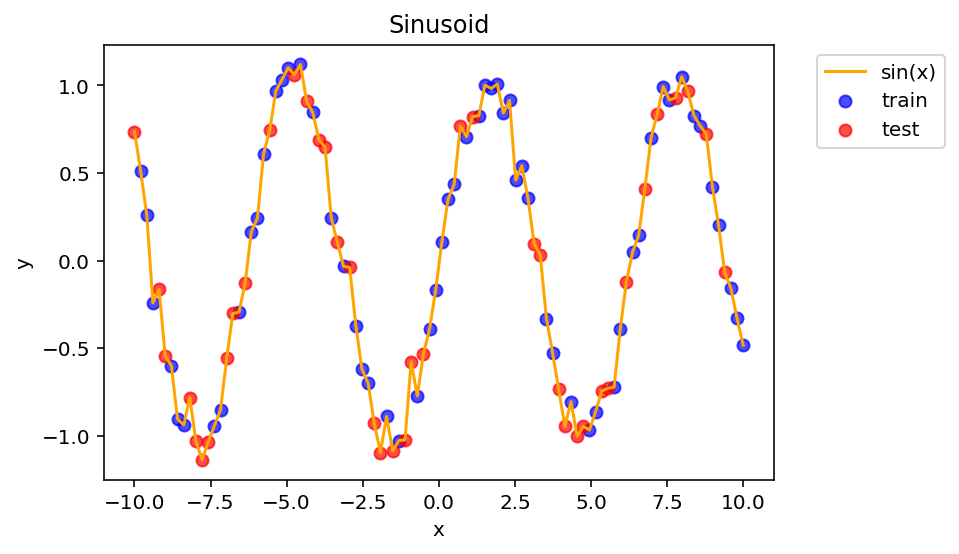

In [3]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4)
plt.plot(x, y, color = 'orange');
plt.scatter(train_x, train_y, c = 'blue', alpha = 0.7);
plt.scatter(test_x, test_y, c='red', alpha = 0.7);
plt.title('Sinusoid');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['sin(x)', 'train', 'test'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [4]:
def get_eucledean(x, exponent):
    d = ((x[:, None] - x)**2).sum(axis=2)**0.5
    # self distance is 0, so replace it with twice of the max distance to give most importance to the current
    d = torch.where(d==0, torch.max(d[d!=0])*2, d)  
    A = 1/(d**exponent)
    return A/A.sum(dim=1, keepdim=True)

In [5]:
def adjacency_matrix_to_edge_list(A):
    edge_list = []
    edge_weights = []
    num_nodes = A.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            edge_weights.append(A[i, j])
            if A[i, j] != 0:
                edge_list.append((i, j))
    
    return torch.tensor(edge_list).T.to(device), torch.tensor(edge_weights).to(device)

In [6]:
train_edge_list, train_edge_weights = adjacency_matrix_to_edge_list(get_eucledean(train_x.unsqueeze(1), 1))
test_edge_list, test_edge_weights = adjacency_matrix_to_edge_list(get_eucledean(test_x.unsqueeze(1), 1))

In [7]:
train_data = Data(x=train_x, edge_index=train_edge_list,edge_weights = train_edge_weights, y=train_y)
test_data = Data(x=test_x, edge_index=test_edge_list,edge_weights = test_edge_weights, y=test_y)

In [8]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.linear1 = nn.Linear(32, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x, edge_index, edge_weights):
        x = self.conv1(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 277.02it/s]


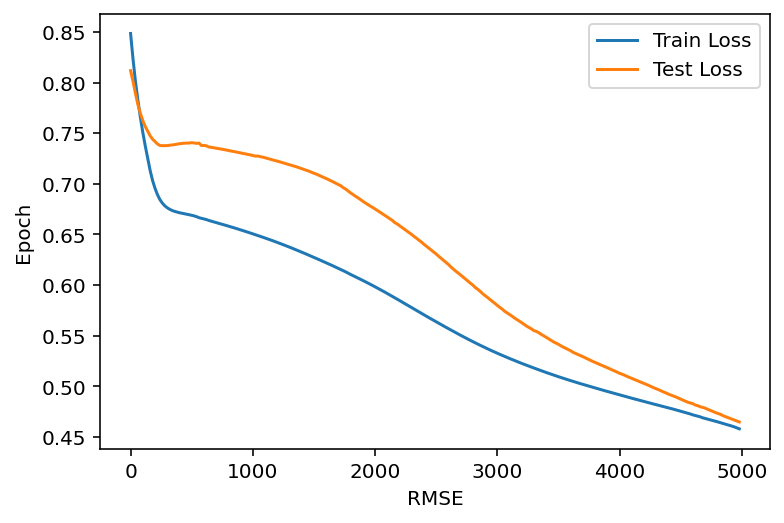

In [9]:
model = RegressionModel(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(5000)):
    optimizer.zero_grad()
    out = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device))
    loss = criterion(out.squeeze().cpu(), train_data.y.squeeze().cpu())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            train_out = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device))  
            test_out = model(test_data.x.unsqueeze(1).to(device), test_data.edge_index.to(device), test_data.edge_weights.to(device))
            train_rmse = torch.sqrt(torch.mean((train_out.squeeze().cpu() - train_data.y.squeeze().cpu())**2))
            test_rmse = torch.sqrt(torch.mean((test_out.squeeze().cpu() - test_data.y.squeeze().cpu())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
  

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.legend()
plt.show()

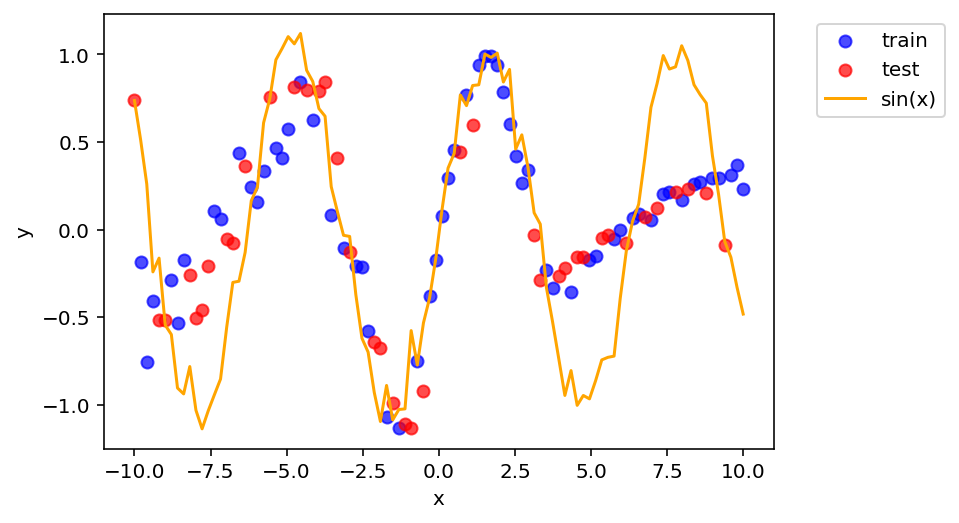

In [10]:
train_pred = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device)).cpu().detach().numpy()
test_pred = model(test_data.x.unsqueeze(1).to(device), test_data.edge_index.to(device), test_data.edge_weights.to(device)).cpu().detach().numpy()
plt.scatter(train_data.x, train_pred, c='blue', alpha=0.7)
plt.scatter(test_data.x, test_pred, c='red', alpha=0.7)
# plt.plot(torch.linspace(-10, 10, n_points), torch.sin(torch.linspace(-10, 10, n_points)))
plt.plot(torch.linspace(-10, 10, n_points), y, color = 'orange')
plt.xlabel('x')
plt.ylabel('y')
plt.legend([ 'train', 'test','sin(x)','pred'],bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# Train and Test Together

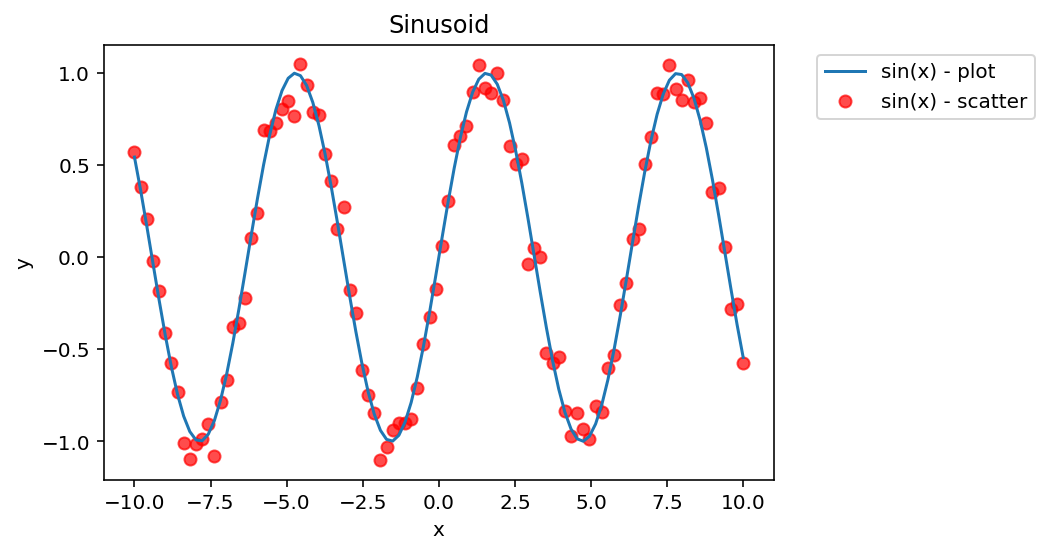

In [11]:
n_points = 100

x = torch.linspace(-10, 10, n_points)

y = torch.sin(x) + torch.randn(n_points) * 0.1
plt.plot(x, torch.sin(x));
plt.scatter(x, y, c = 'red', alpha = 0.7);
plt.title('Sinusoid');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['sin(x) - plot', 'sin(x) - scatter'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

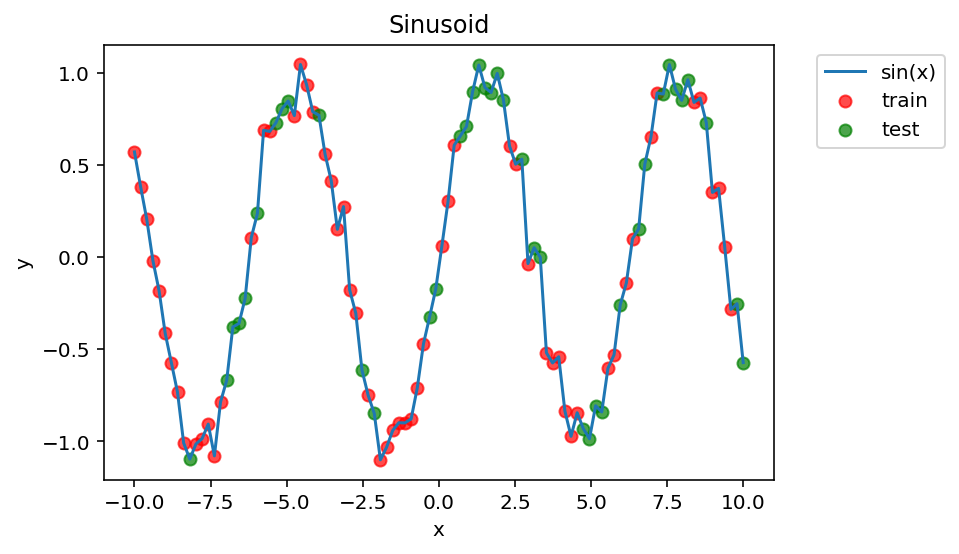

In [12]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4)
plt.plot(x, y);
plt.scatter(train_x, train_y, c = 'red', alpha = 0.7);
plt.scatter(test_x, test_y, c='green', alpha = 0.7);
plt.title('Sinusoid');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['sin(x)', 'train', 'test'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [13]:
edge_list, edge_weights = adjacency_matrix_to_edge_list(get_eucledean(x.unsqueeze(1), 1))

In [14]:
train_mask = torch.zeros(x.shape[0], dtype=torch.bool)
test_mask = torch.zeros(x.shape[0], dtype=torch.bool)
for i in range(x.shape[0]):
    if x[i] in train_x:
        train_mask[i] = True
    else:
        test_mask[i] = True

In [15]:
data = Data(x=x, edge_index=edge_list,edge_weights = edge_weights, y=y, train_mask=train_mask, test_mask=test_mask).to(device)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 126.38it/s]


Train RMSE 0.36311322
Test RMSE 0.3756791


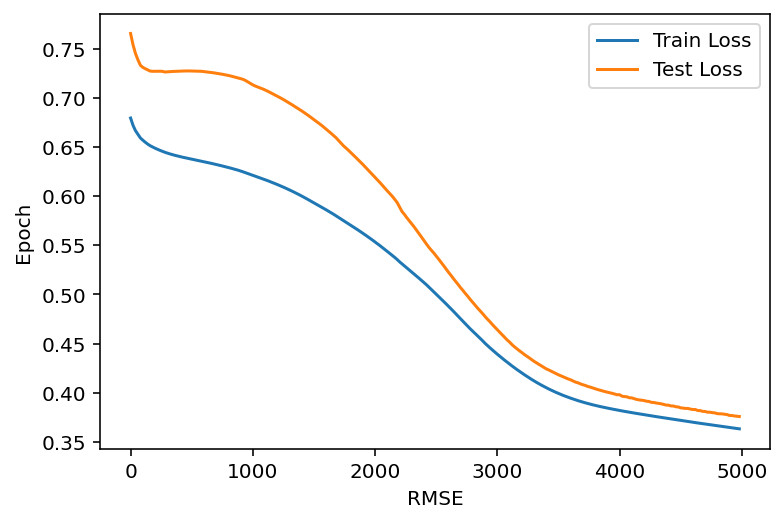

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionModel(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(5000)):
    optimizer.zero_grad()
    out = model(data.x.unsqueeze(1).to(device), data.edge_index.to(device), data.edge_weights.to(device))
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.unsqueeze(1).to(device), data.edge_index.to(device),data.edge_weights.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
with torch.no_grad():
    out = model(data.x.unsqueeze(1).to(device), data.edge_index.to(device),data.edge_weights.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print("Train RMSE", train_rmse.cpu().numpy())
    print("Test RMSE", test_rmse.cpu().numpy())        

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.legend()
plt.show()

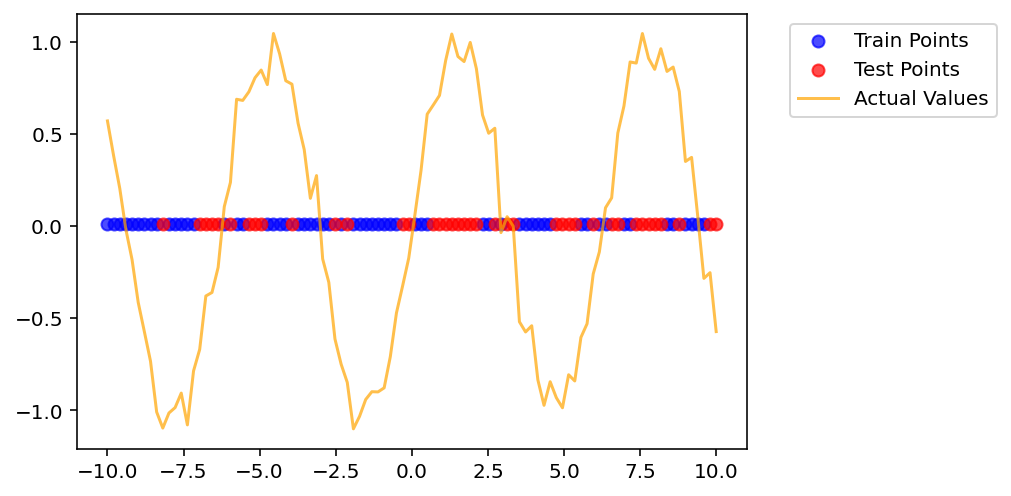

In [17]:
out = model(data.x.unsqueeze(1).to(device), data.edge_index.to(device),data.edge_weight)  # Predicted PM values
train_preds = out[data.train_mask].cpu().squeeze().detach().numpy()
test_preds = out[data.test_mask].cpu().squeeze().detach().numpy()

plt.scatter(data.x[data.train_mask].cpu(), train_preds, color = 'blue', label = 'Train Points', alpha = 0.7)
plt.scatter(data.x[data.test_mask].cpu(), test_preds, color = 'red', label = 'Test Points',alpha = 0.7)
plt.plot(x, y, label = 'Actual Values', color = 'orange', alpha = 0.7)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

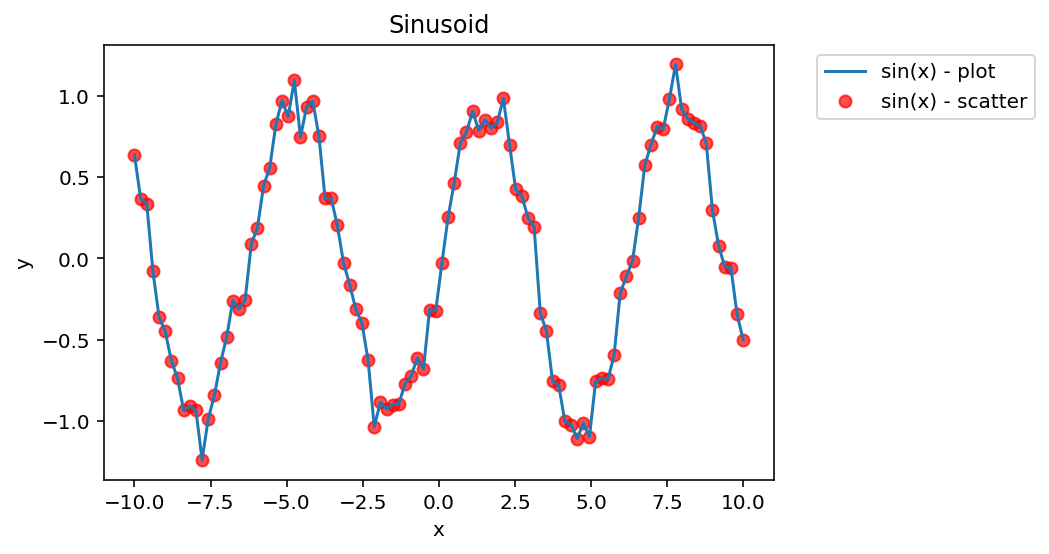

In [18]:
n_points = 100

x = torch.linspace(-10, 10, n_points)

y = torch.sin(x) + torch.randn(n_points) * 0.1
plt.plot(x, y);
plt.scatter(x, y, c = 'red', alpha = 0.7);
plt.title('Sinusoid');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['sin(x) - plot', 'sin(x) - scatter'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

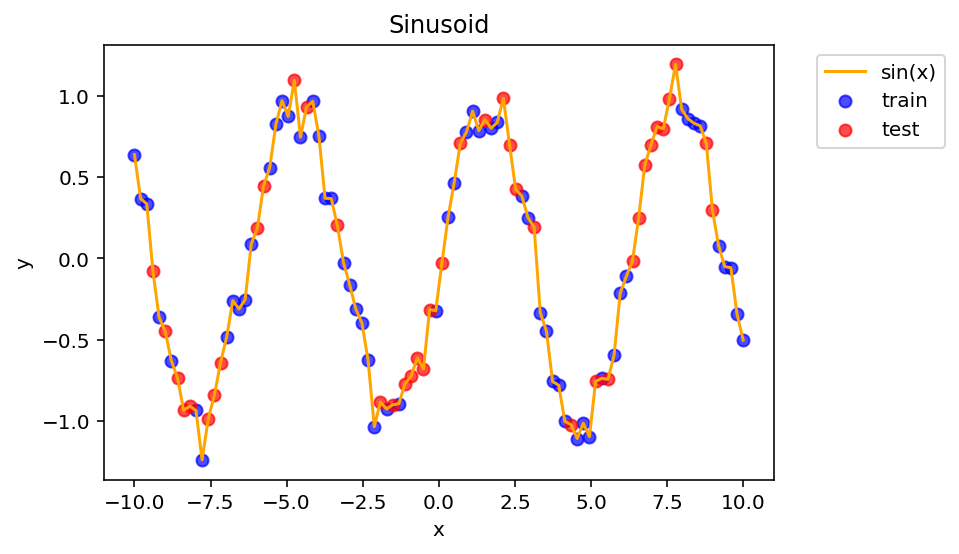

In [19]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4)
plt.plot(x, y, color = 'orange');
plt.scatter(train_x, train_y, c = 'blue', alpha = 0.7);
plt.scatter(test_x, test_y, c='red', alpha = 0.7);
plt.title('Sinusoid');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['sin(x)', 'train', 'test'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [20]:
train_mask = torch.zeros(x.shape[0], dtype=torch.bool)
test_mask = torch.zeros(x.shape[0], dtype=torch.bool)
for i in range(x.shape[0]):
    if x[i] in train_x:
        train_mask[i] = True
    else:
        test_mask[i] = True

In [21]:
def edge_list(x):
    edge_list = []
    for i in range(len(x)):  
            for j in range(i+1, i+5):
                if j >= len(x):
                    break
                edge_list.append((i, j))
    return torch.tensor(edge_list).T

In [22]:
edge_list = edge_list(x)

In [23]:
data = Data(x=x, edge_index=edge_list, y=y, train_mask=train_mask, test_mask=test_mask).to(device)

In [24]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.linear1 = nn.Linear(32, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 613.40it/s]


Train RMSE 0.4096855
Test RMSE 0.5349958


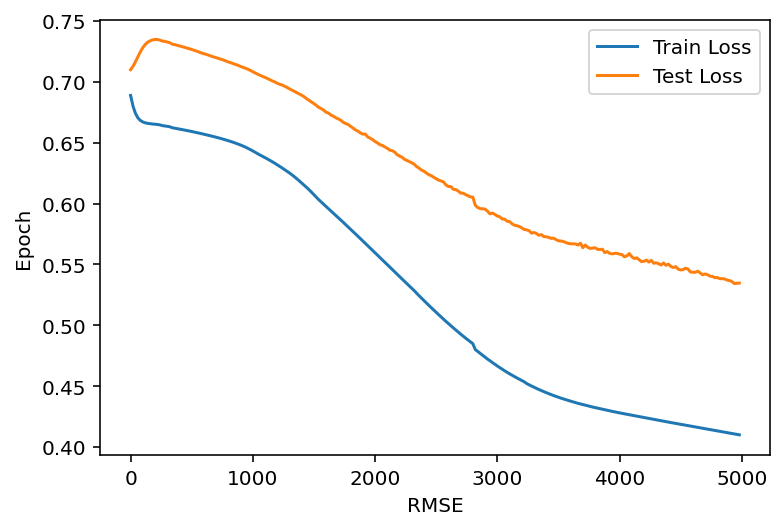

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionModel(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(5000)):
    optimizer.zero_grad()
    out = model(data.x.unsqueeze(1).to(device), data.edge_index.to(device))
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.unsqueeze(1).to(device), data.edge_index.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
with torch.no_grad():
    out = model(data.x.unsqueeze(1).to(device), data.edge_index.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print("Train RMSE", train_rmse.cpu().numpy())
    print("Test RMSE", test_rmse.cpu().numpy())        

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.legend()
plt.show()

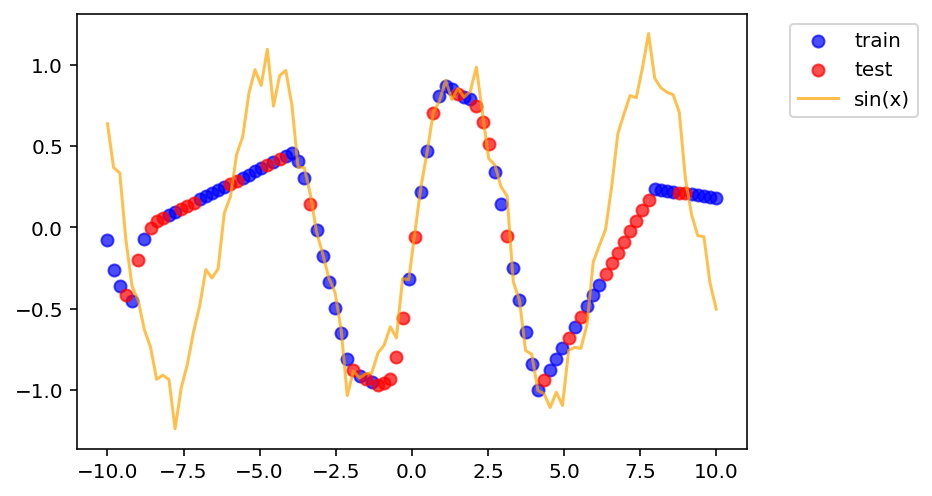

In [26]:
out = model(data.x.unsqueeze(1).to(device), data.edge_index.to(device))  # Predicted PM values
train_preds = out[data.train_mask].cpu().squeeze().detach().numpy()
test_preds = out[data.test_mask].cpu().squeeze().detach().numpy()

plt.scatter(data.x[data.train_mask].cpu(), train_preds, color = 'blue', label = 'train', alpha = 0.7)
plt.scatter(data.x[data.test_mask].cpu(), test_preds, color = 'red', label = 'test',alpha = 0.7)
plt.plot(x, y, label = 'sin(x)', color = 'orange', alpha = 0.7)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# Using GPy RBF

torch.Size([50, 1]) torch.Size([50, 1]) torch.Size([50, 1])


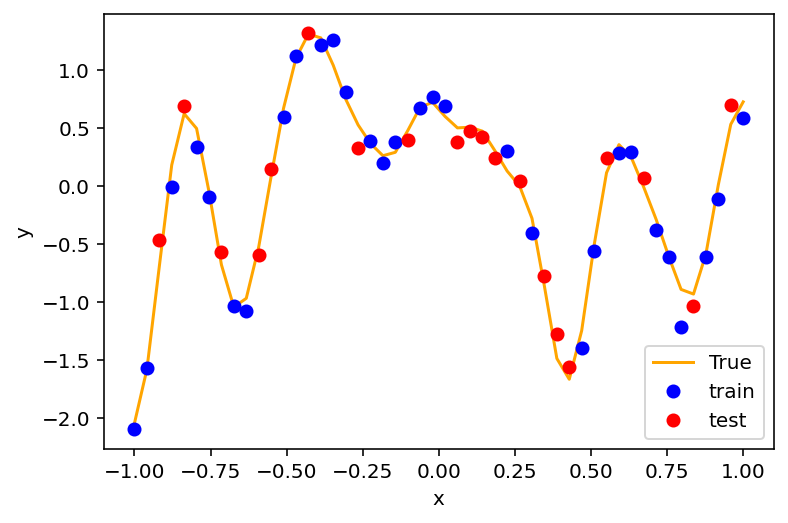

In [27]:
N = 50
x = np.linspace(-1, 1, N).reshape(-1, 1)
kernel = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=0.1)
y = np.random.multivariate_normal(np.zeros(N), kernel.K(x)).reshape(-1, 1)
y_noisy = y + np.random.normal(0, 0.1, N).reshape(-1, 1)

train_x, test_x, train_y, test_y = train_test_split(x, y_noisy, test_size=0.4, random_state=0)

plt.plot(x, y, label="True", color = 'orange');
plt.plot(train_x, train_y, 'o', label='train', color = 'blue')
plt.plot(test_x, test_y, 'o', label='test', color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

x, y, y_noisy = map(lambda x: torch.tensor(x).float().to(device), (x, y, y_noisy))
train_x, test_x, train_y, test_y = map(lambda x: torch.tensor(x).float().to(device), (train_x, test_x, train_y, test_y))
print(x.shape, y.shape, y_noisy.shape)

In [28]:
x.shape

torch.Size([50, 1])

In [29]:
train_mask = torch.zeros(x.shape[0], dtype=torch.bool)
test_mask = torch.zeros(x.shape[0], dtype=torch.bool)
for i in range(x.shape[0]):
    if x[i] in train_x:
        train_mask[i] = True
    else:
        test_mask[i] = True

In [30]:
def edge_list(x):
    edge_list = []
    for i in range(len(x)):  
            for j in range(i+1, i+5):
                if j >= len(x):
                    break
                edge_list.append((i, j))
    return torch.tensor(edge_list).T

In [31]:
edge_list = edge_list(x)

In [32]:
train_mask.shape, test_mask.shape, edge_list.shape, y_noisy.shape,x.shape

(torch.Size([50]),
 torch.Size([50]),
 torch.Size([2, 190]),
 torch.Size([50, 1]),
 torch.Size([50, 1]))

In [33]:
data = Data(x=x, edge_index=edge_list, y=y_noisy.squeeze(), train_mask=train_mask, test_mask=test_mask).to(device)

In [34]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.linear1 = nn.Linear(32, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [35]:
model = RegressionModel(1).to(device)
out = model(data.x.to(device), data.edge_index.to(device))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 628.18it/s]


Train RMSE 0.566468
Test RMSE 0.5807107


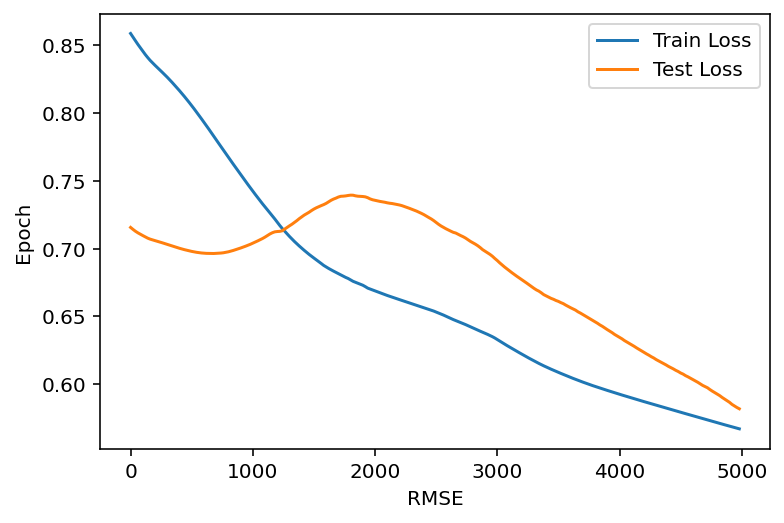

In [36]:
model = RegressionModel(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(5000)):
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
with torch.no_grad():
    out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print("Train RMSE", train_rmse.cpu().numpy())
    print("Test RMSE", test_rmse.cpu().numpy())        

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.legend()
plt.show()

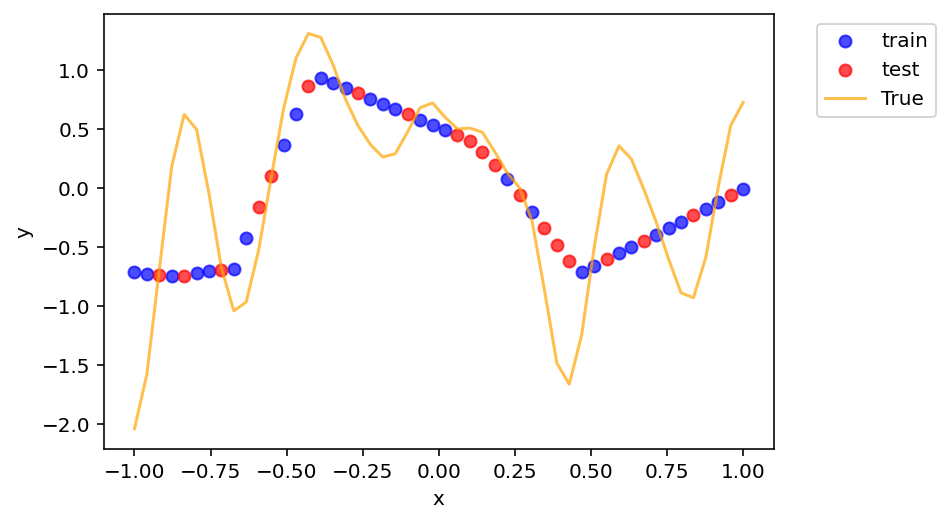

In [37]:
out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
train_preds = out[data.train_mask].cpu().squeeze().detach().numpy()
test_preds = out[data.test_mask].cpu().squeeze().detach().numpy()

plt.scatter(data.x[data.train_mask].cpu(), train_preds, color = 'blue', label = 'train', alpha = 0.7)
plt.scatter(data.x[data.test_mask].cpu(), test_preds, color = 'red', label = 'test',alpha = 0.7)
plt.plot(x.cpu(), y.cpu(), label = 'True', color = 'orange', alpha = 0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [38]:
def get_eucledean(x, exponent):
    d = ((x[:, None] - x)**2).sum(axis=2)**0.5
    # self distance is 0, so replace it with twice of the max distance to give most importance to the current
    d = torch.where(d==0, torch.max(d[d!=0])*2, d)  
    A = 1/(d**exponent)
    return A/A.sum(dim=1, keepdim=True)

In [39]:
def adjacency_matrix_to_edge_list(A):
    edge_list = []
    edge_weights = []
    num_nodes = A.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            edge_weights.append(A[i, j])
            if A[i, j] != 0:
                edge_list.append((i, j))
    
    return torch.tensor(edge_list).T.to(device), torch.tensor(edge_weights).to(device)

In [40]:
train_edge_list, train_edge_weights = adjacency_matrix_to_edge_list(get_eucledean(train_x.unsqueeze(1), 1))
test_edge_list, test_edge_weights = adjacency_matrix_to_edge_list(get_eucledean(test_x.unsqueeze(1), 1))

In [41]:
train_data = Data(x=train_x.squeeze(), edge_index=train_edge_list,edge_weights = train_edge_weights, y=train_y)
test_data = Data(x=test_x.squeeze(), edge_index=test_edge_list,edge_weights = test_edge_weights, y=test_y)

In [42]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.linear1 = nn.Linear(32, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x, edge_index, edge_weights):
        x = self.conv1(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 486.01it/s]


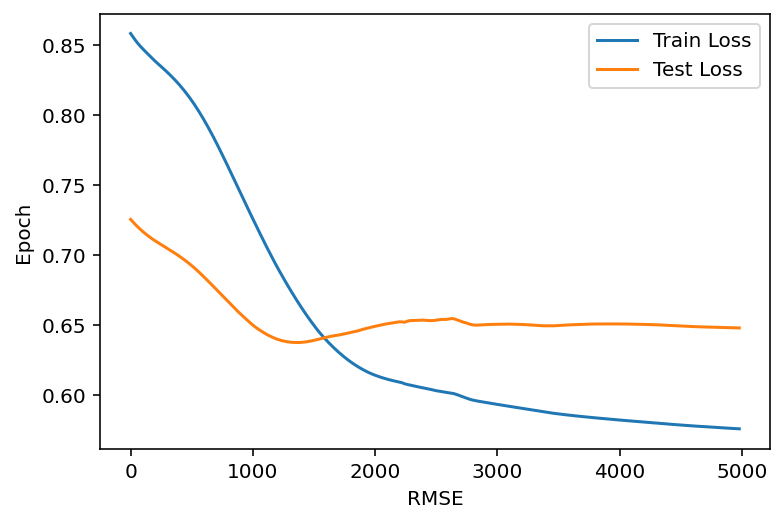

In [43]:
model = RegressionModel(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(5000)):
    optimizer.zero_grad()
    out = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device))
    loss = criterion(out.squeeze().cpu(), train_data.y.squeeze().cpu())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            train_out = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device))  
            test_out = model(test_data.x.unsqueeze(1).to(device), test_data.edge_index.to(device), test_data.edge_weights.to(device))
            train_rmse = torch.sqrt(torch.mean((train_out.squeeze().cpu() - train_data.y.squeeze().cpu())**2))
            test_rmse = torch.sqrt(torch.mean((test_out.squeeze().cpu() - test_data.y.squeeze().cpu())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
  

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.legend()
plt.show()

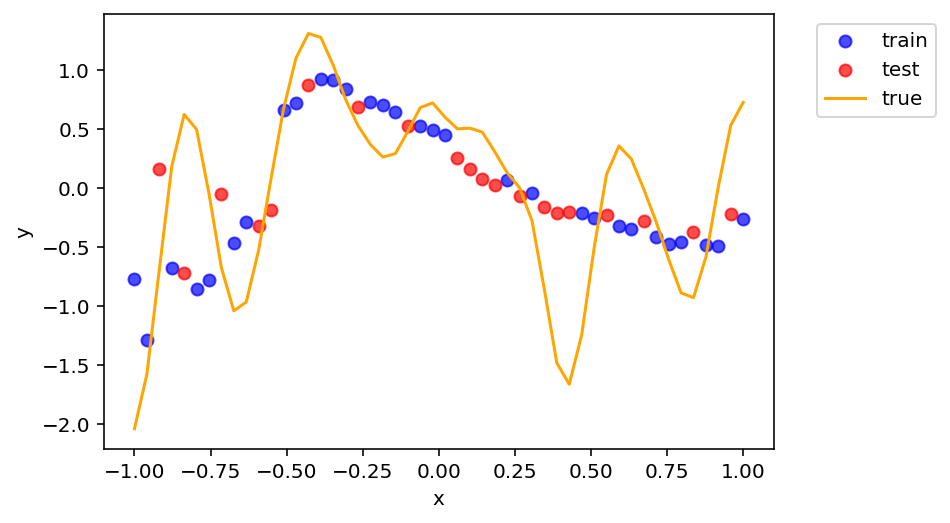

In [44]:
train_pred = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device)).cpu().detach().numpy()
test_pred = model(test_data.x.unsqueeze(1).to(device), test_data.edge_index.to(device), test_data.edge_weights.to(device)).cpu().detach().numpy()
plt.scatter(train_data.x, train_pred, c='blue', alpha=0.7)
plt.scatter(test_data.x, test_pred, c='red', alpha=0.7)
# plt.plot(torch.linspace(-10, 10, n_points), torch.sin(torch.linspace(-10, 10, n_points)))
plt.plot(x, y, color = 'orange')
plt.xlabel('x')
plt.ylabel('y')
plt.legend([ 'train', 'test','true'],bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()